In [3]:
import os
from PIL import Image
from torchvision import transforms
from torchvision.transforms import functional as TF
import random
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

class RotatedDigitsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images, self.labels = self.load_images()

    def load_images(self):
        images, labels = [], []
        for digit in range(10):
            digit_dir = os.path.join(self.root_dir, str(digit))
            for filename in os.listdir(digit_dir):
                img_path = os.path.join(digit_dir, filename)
                image = Image.open(img_path).convert('L')  # 转换为灰度图像
                images.append(image)
                labels.append(digit)  # 标签为数字本身
        return images, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image = self.images[idx]
        label = self.labels[idx]

        # 添加随机旋转作为数据增强
        rotation_angle = random.randint(0, 359)
        image = TF.rotate(image, rotation_angle)

        if self.transform:
            image = self.transform(image)
        
        return image, label

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 加载数据集


In [4]:
dataset = RotatedDigitsDataset(root_dir='C:\\Users\\22597\\Documents\\GitHub\\boiling\\trainpic', transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

import torch.nn.functional as F
# 定义模型
class RotationClassifier(nn.Module):
    def __init__(self):
        super(RotationClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(32 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 360)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 32 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 实例化模型
model = RotationClassifier()

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 1500
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f'Epoch {epoch + 1}, Loss: {running_loss / (i + 1)}')

print('Finished Training')

Epoch 1, Loss: 3.017017975449562
Epoch 2, Loss: 1.8873995169997215
Epoch 3, Loss: 1.4609239883720875
Epoch 4, Loss: 1.2460040301084518
Epoch 5, Loss: 1.030248774215579
Epoch 6, Loss: 0.9947114419192076
Epoch 7, Loss: 0.8507366813719273
Epoch 8, Loss: 0.7973656021058559
Epoch 9, Loss: 0.705312741920352
Epoch 10, Loss: 0.6957485415041447
Epoch 11, Loss: 0.6203056359663606
Epoch 12, Loss: 0.6243125209584832
Epoch 13, Loss: 0.6009240131825209
Epoch 14, Loss: 0.5189346130937338
Epoch 15, Loss: 0.5582187585532665
Epoch 16, Loss: 0.5084573328495026
Epoch 17, Loss: 0.4573661289177835
Epoch 18, Loss: 0.4619010682217777
Epoch 19, Loss: 0.418425299692899
Epoch 20, Loss: 0.42727195005863905
Epoch 21, Loss: 0.4033320345915854
Epoch 22, Loss: 0.40770662669092417
Epoch 23, Loss: 0.39251397270709276
Epoch 24, Loss: 0.3839723845012486
Epoch 25, Loss: 0.3734549833461642
Epoch 26, Loss: 0.3765504788607359
Epoch 27, Loss: 0.35478616086766124
Epoch 28, Loss: 0.32502447720617056
Epoch 29, Loss: 0.3066784455

In [8]:
# 假设 model 是你训练完成的模型实例
torch.save(model.state_dict(), 'C:\\Users\\22597\\Documents\\GitHub\\boiling\\4rotation\\model\\rotationCNN1500epoch.pth')

In [9]:
# model = RotationClassifier()

# model.load_state_dict(torch.load('path/to/your/model_weights.pth'))

# 确保模型处于评估模式
model.eval()

# 加载图像
image_path = 'img_to_rotate3.png'
image = Image.open(image_path).convert('L')  # 转换为灰度图像

# 应用相同的预处理
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
image = transform(image)
image = image.unsqueeze(0)  # 添加batch维度

with torch.no_grad():
    output = model(image)

    # 解析输出
probabilities = torch.nn.functional.softmax(output[0], dim=0)
predicted_angle = torch.argmax(probabilities).item()

print(f"Predicted rotation angle: {predicted_angle} degrees")

Predicted rotation angle: 3 degrees


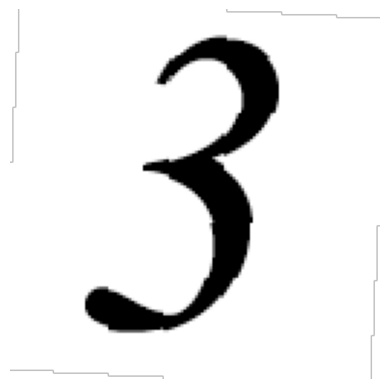

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# 读取原始图像
original_image = Image.open(image_path)

# 定义旋转角度，注意这里是负数，因为PIL的rotate函数是逆时针旋转
angle = -predicted_angle

# 创建旋转转换
rotate_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Lambda(lambda img: img.rotate(angle)),  # Lambda用于应用任意函数
    transforms.ToTensor()
])

# 旋转图像并转换为张量
rotated_image_tensor = rotate_transform(original_image)

# 将张量转换回PIL图像以便显示
rotated_image = transforms.ToPILImage()(rotated_image_tensor)

# 显示旋转后的图像
plt.imshow(rotated_image)
plt.axis('off')  # 可选，隐藏坐标轴
plt.show()